# Eurovision Song Contest - Voting Analysis

## 1. Set up

### 1.1 Import packages

In [76]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from esc.utils import country_names

### 1.2 Load data

In [2]:
notebook_dir = os.getcwd()
data_dir = 'data'
data_name = 'votes.csv'

votes_data_path = os.path.join(notebook_dir, data_dir, data_name)

votes_data = pd.read_csv(votes_data_path)

In [3]:
votes_data.tail(10)

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
51344,2023,final,wld,es,wld,es,2,2.0,NaN
51345,2023,final,wld,md,wld,md,0,0.0,NaN
51346,2023,final,wld,pl,wld,pl,0,0.0,NaN
51347,2023,final,wld,ch,wld,ch,0,0.0,NaN
51348,2023,final,wld,si,wld,si,0,0.0,NaN
51349,2023,final,wld,al,wld,al,6,6.0,NaN
51350,2023,final,wld,pt,wld,pt,0,0.0,NaN
51351,2023,final,wld,rs,wld,rs,0,0.0,NaN
51352,2023,final,wld,gb,wld,gb,0,0.0,NaN
51353,2023,final,wld,de,wld,de,0,0.0,NaN


## 2. Preliminary Analysis

### 2.1 Country IDs

In [4]:
country_ids = set()

for id in votes_data['from_country_id'].values:
    country_ids.add(id)

list(country_ids)[:5]

['de', 'ad', 'ge', 'at', 'be']

### 2.2 Number of participations

In [5]:
# Get the IDs per year
unique_ids_per_year = votes_data.groupby('year')['from_country_id'].unique()

In [9]:
from collections import Counter

# Get the number of participations per ID, rank them

total_ids = []

for year in unique_ids_per_year.index:
    total_ids.extend(unique_ids_per_year[year])

participations = Counter(total_ids)

In [11]:


# Turn the IDs into the country names
participations_dict = {}

for id, num_entries in participations.items():
    name = country_names[id]
    participations_dict[name] = num_entries

In [15]:
# Sort and display
sorted_participations = sorted(participations_dict, key=participations_dict.get, reverse=True)

for country in sorted_participations:
    num_entries = participations_dict[country]
    print(f"{country}: {num_entries} entries")


Germany: 65 entries
United Kingdom: 65 entries
France: 64 entries
Belgium: 63 entries
Netherlands: 62 entries
Switzerland: 62 entries
Sweden: 62 entries
Spain: 62 entries
Norway: 61 entries
Finland: 56 entries
Ireland: 56 entries
Austria: 55 entries
Portugal: 54 entries
Denmark: 51 entries
Italy: 47 entries
Israel: 45 entries
Greece: 43 entries
Cyprus: 39 entries
Luxembourg: 36 entries
Iceland: 35 entries
Turkey: 34 entries
Croatia: 28 entries
Slovenia: 28 entries
Estonia: 28 entries
Yugoslavia: 27 entries
Poland: 25 entries
Monaco: 24 entries
Lithuania: 23 entries
Romania: 23 entries
Russia: 23 entries
Latvia: 23 entries
North Macedonia: 21 entries
Bosnia and Herzegovina: 19 entries
Albania: 19 entries
Ukraine: 18 entries
Moldova: 18 entries
Hungary: 17 entries
Belarus: 16 entries
Armenia: 15 entries
Georgia: 15 entries
Serbia: 15 entries
Azerbaijan: 15 entries
Bulgaria: 14 entries
San Marino: 13 entries
Montenegro: 12 entries
Czech Republic: 11 entries
Australia: 8 entries
Slovakia: 

### 2.3 Number of points given to other countries

In [67]:
votes_data.groupby('from_country_id')['total_points'].mean()

# Create graph per year with number of points on the edges

# Create function that turns dataframe into graph
import networkx as nx

def dataframe_to_graph(df):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes for countries
    G.add_nodes_from(df['from_country_id'].unique())
    G.add_nodes_from(df['to_country_id'].unique())

    # Add edges between countries with the total points as the edge weight
    for _, row in df.iterrows():
        from_country = row['from_country_id']
        to_country = row['to_country_id']
        total_points = row['total_points']

        if total_points <= 0:
            continue

        if from_country != to_country:  # Avoid self-loops
            if G.has_edge(from_country, to_country):
                # If edge already exists, add the points to the existing weight
                G[from_country][to_country]['weight'] += total_points
            else:
                # Otherwise, add a new edge with the points as weight
                G.add_edge(from_country, to_country, weight=total_points)

    return G

year = 2000

year_df = votes_data[votes_data['year'] > year]
# year_df = votes_data

round_ = 'final'

df = year_df[year_df['round'] == round_]

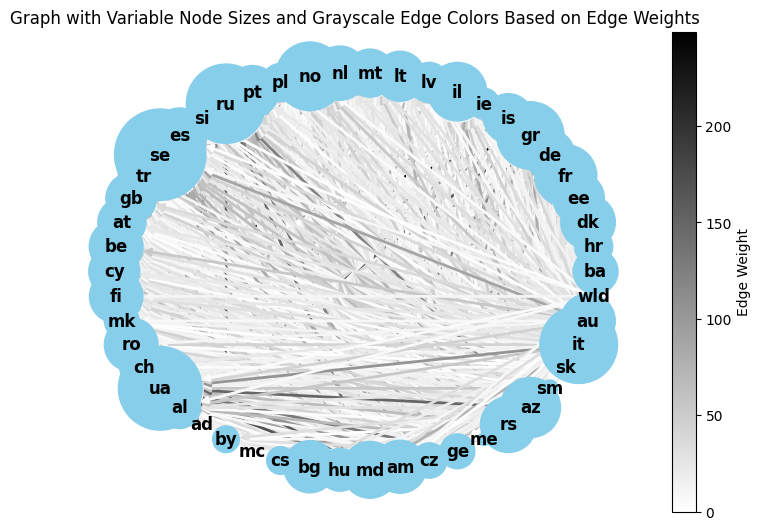

In [68]:
G = dataframe_to_graph(df)

# Calculate node sizes based on the sum of edge weights
node_sizes = [sum(weight for _, _, weight in G.in_edges(node, data='weight')) for node in G.nodes()]

# Calculate edge colors based on the weight of the edges
edge_weights = nx.get_edge_attributes(G, 'weight')
max_weight = max(edge_weights.values())
edge_colors = [weight / max_weight for _, _, weight in G.edges(data='weight')]

# Map the normalized weights to grayscale colors
edge_colors = [plt.cm.gray_r(weight) for weight in edge_colors]

# Draw the graph with variable node sizes and grayscale edge colors
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=node_sizes, font_size=12, font_weight='bold', edge_color=edge_colors, width=2)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.gray_r, norm=plt.Normalize(vmin=0, vmax=max_weight))
sm._A = []
cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.05, pad=0.04)
cbar.set_label('Edge Weight')

# Show the graph
plt.title("Graph with Variable Node Sizes and Grayscale Edge Colors Based on Edge Weights")
plt.show()

In [75]:
import community

undirected_G = G.to_undirected()

# Detect communities using the Louvain method
partition = community.best_partition(undirected_G, resolution=1.1)

# Group countries into voter blocs based on community detection results
voter_blocs = {}
for country, bloc_id in partition.items():
    if bloc_id not in voter_blocs:
        voter_blocs[bloc_id] = []
    voter_blocs[bloc_id].append(country)

# Print the voter blocs
for bloc_id, countries in voter_blocs.items():
    full_names = [country_names[country] for country in countries]

    print(f"Voter Bloc {bloc_id}: {full_names}")

Voter Bloc 0: ['Bosnia and Herzegovina', 'Croatia', 'Slovenia', 'North Macedonia', 'Serbia and Montenegro', 'Montenegro', 'Serbia', 'Italy']
Voter Bloc 1: ['Denmark', 'Estonia', 'Iceland', 'Ireland', 'Latvia', 'Lithuania', 'Malta', 'Norway', 'Poland', 'Sweden', 'United Kingdom', 'Finland', 'Slovakia', 'Australia', 'World']
Voter Bloc 2: ['France', 'Germany', 'Portugal', 'Spain', 'Switzerland', 'Andorra', 'Monaco']
Voter Bloc 3: ['Greece', 'Cyprus', 'Romania', 'Albania', 'Bulgaria']
Voter Bloc 4: ['Israel', 'Russia', 'Ukraine', 'Belarus', 'Moldova', 'Armenia', 'Czech Republic', 'Georgia', 'Azerbaijan', 'San Marino']
Voter Bloc 5: ['Netherlands', 'Turkey', 'Austria', 'Belgium', 'Hungary']
